# `QSDsan Workshop ` <a class="anchor" id="top"></a>

- **Prepared by:**
    
    - [Yalin Li](https://qsdsan.readthedocs.io/en/latest/authors/Yalin_Li.html)

- **Covered topics:**

    - [0. Binder Overview](#s0)
    - [1. Systems](#s1)
    - [2. Uncertainty and Sensitivity Analyses](#s2)
    - [3. Country-Specific Analysis](#s3)

#!!! Link needs to bo updated
To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan/main?filepath=%2Fdocs%2Fsource%2Ftutorials).

In [1]:
#!!! Delete when testing with the released `qsdsan`
import os, sys
pwd = sys.path[0]
for abbr in ('tmo', 'bst', 'qs'):
    sys.path.append(os.path.abspath(os.path.join(pwd, f'../{abbr}')))
sys.path

['/Users/yalinli_cabbi/Library/CloudStorage/OneDrive-Personal/Coding/workshop',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python38.zip',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python3.8',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python3.8/site-packages',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python3.8/site-packages/aeosa',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg',
 '/Users/yalinli_cabbi/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions',
 '/Users/yalinli_cabbi/.ipython',
 '/Users/yalinli_cabbi/Library/CloudStorage/OneDrive-Personal/Coding/tmo',
 '/Users/yalinli_cabbi/Library/CloudStorage/OneDrive-Personal/Coding/bst',
 '/Users/yalinli_cabbi/Library/CloudStorage/OneDrive-Personal/Coding/qs']

## 0. Binder Overview
A reminder to briefly go over how to use binder to run Jupyter Notebook.

[Back to top](#top)

## 1. Systems <a class="anchor" id="s1"></a>

As we introduced earlier in this workshop, in this example we are from a community deciding which kind of toilets we would like to install.

We have two options: pit latrine or urine-diverting dry toilet (UDDT). The pit latrine is cheaper, but the excreta may leach into the environment, and the low emptying frequency of it leads to more organic degradation that releases methane and N2O. UDDT, on the other hand, has higher capital and operating costs, but it separates urine from the solid wastes, thus can recovery more nutrients (N, P, and K). It is also cleaned at a more higher frequency than the pit latrine, therefore releases much less greenhouse gases (GHGs).

In [2]:
# Let's have a look at the system
# `sysA` is the system for pit latrine and `sysB` for UDDT
from systems import sysA, sysB

As we can see, for both systems we include the human excreta input units (`A1`, `B1`), the toilets (`A2`, `B2`), the transportation units (`A3`, `B3`&`B4`).

Additionally, the the crop application units (`A4`, `B5`&`B6`) are used to account for the handling loss of the nutrients in the excreta, fugitative mixers (`A5`&`A6`, `B7`&`B8`) are used to record how the fugitative methane and N2O, and the splitters (`A7`, `B9`&`B10`) are used for easy calculation of the nutrient recoveries.

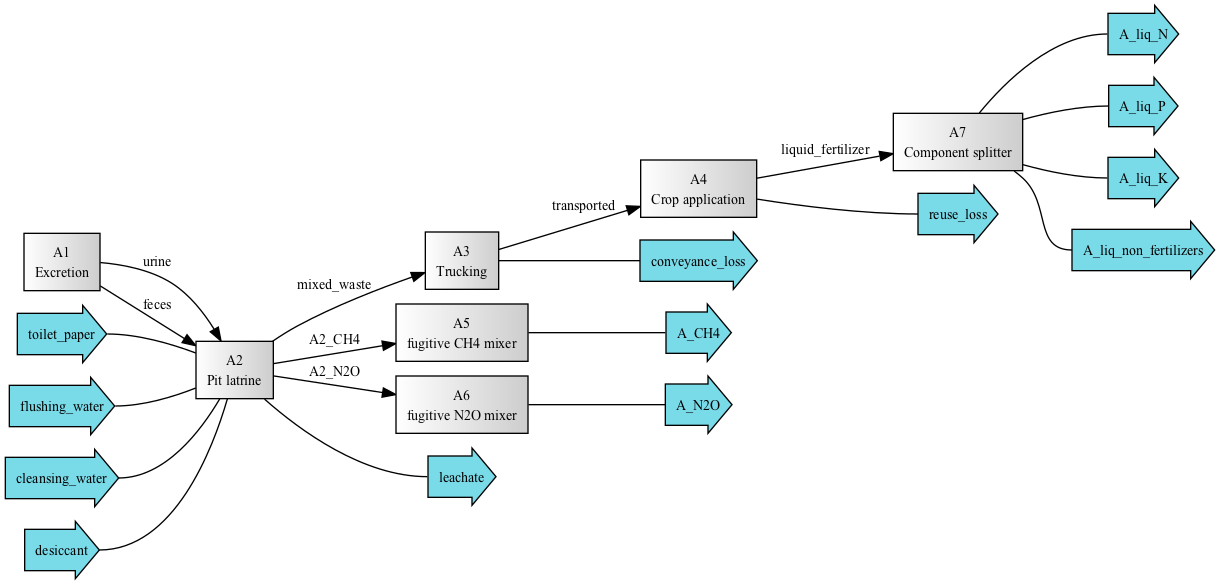

In [3]:
sysA.diagram()

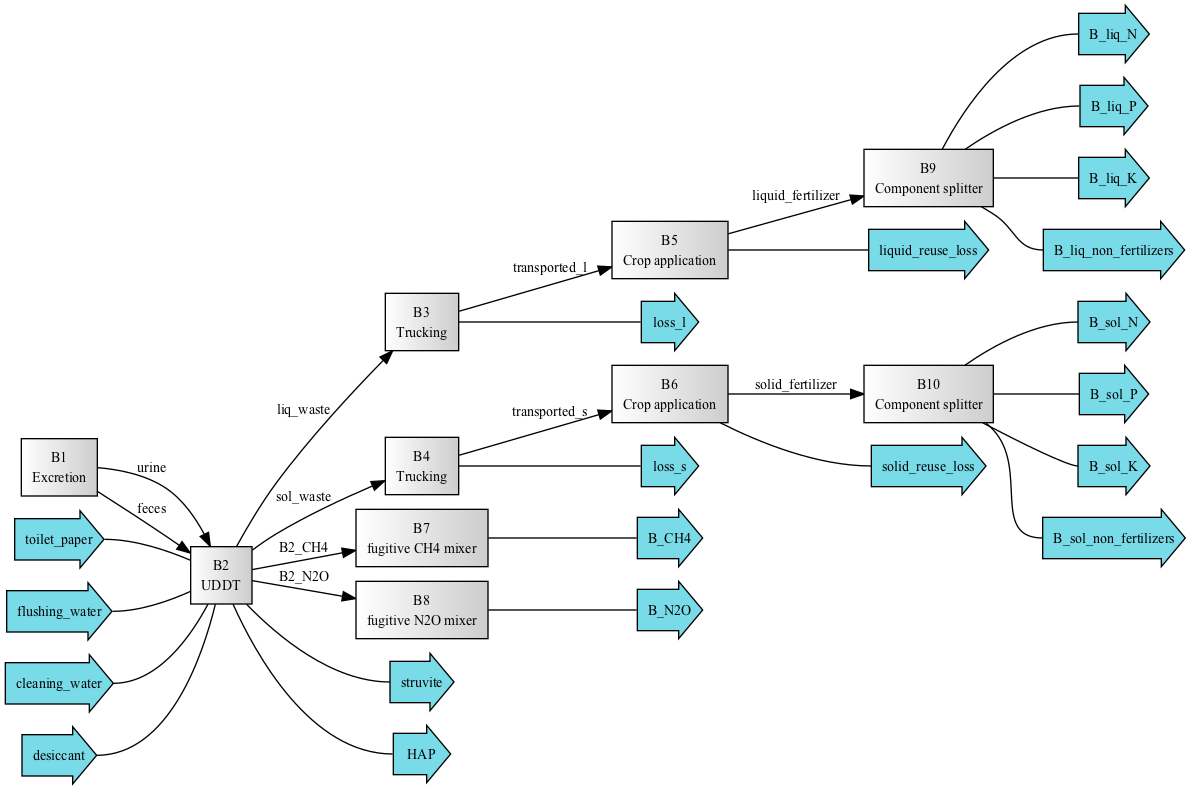

In [4]:
sysB.diagram()

In [5]:
# To get a quick peek of the results
from systems import (
    sysA, sysB,
    get_daily_cap_cost as get_cost,
    get_daily_cap_ghg as get_ghg,
    run_mcda,
    )

for sys in (sysA, sysB):
    get_cost(sys)
    get_ghg(sys)
baseline_scores = run_mcda()

Daily net cost for sysA is ¢1.74/cap/d.
Daily net emission for sysA is 62.8 g CO2-e/cap/d.
Daily net cost for sysB is ¢3.35/cap/d.
Daily net emission for sysB is -5.2 g CO2-e/cap/d.
The score for sysA is 0.283, for sysB is 0.717, sysB is selected.


[Back to top](#top)

## 2. Uncertainty and Sensitivity Analyses <a class="anchor" id="s2"></a>

PAUSED HERE TO ADD MORE DETAILED INSTRUCTIONS

In [6]:
from models import create_model, run_uncertainty
from qsdsan import stats as s
from qsdsan.utils import copy_samples

modelA = create_model('A')
modelB = create_model('B')
modelAB = modelA, modelB

def run_uncertainties(N=100, seed=None, rule='L',
                      percentiles=(0, 0.05, 0.25, 0.5, 0.75, 0.95, 1),):
    for model in modelAB:
        run_uncertainty(model, N, seed, rule, percentiles,
                        only_load_samples=True, only_organize_results=False)
    copy_samples(modelA, modelB)

    for model in modelAB:
        run_uncertainty(model, N, seed, rule, percentiles,
                        only_load_samples=False, only_organize_results=False)

    return modelA, modelB

def get_param_metric(name, model, kind='parameter'):
    kind = 'parameters' if kind.lower() in ('p', 'param', 'parameter', 'parameters') \
        else 'metrics'
    for obj in getattr(model, kind):
        if obj.name == name: break
    return obj

def get_param_metric(name, model, kind='parameter'):
    kind = 'parameters' if kind.lower() in ('p', 'param', 'parameter', 'parameters') \
        else 'metrics'
    for obj in getattr(model, kind):
        if obj.name == name: break
    return obj

In [7]:
# Run the models
run_uncertainties()

(<Model: N recovery, P recovery, K recovery, Net cost, CAPEX, OPEX, sales, Net emission, Construction, Transportation, Direct, Offset>,
 <Model: N recovery, P recovery, K recovery, Net cost, CAPEX, OPEX, sales, Net emission, Construction, Transportation, Direct, Offset>)

In [8]:
# QSDsan also has handy plotting functions to quickly visualize the results
recoveries = [get_param_metric(name, modelB, 'metric')
              for name in ('N recovery', 'P recovery', 'K recovery')]
fig, ax = s.plot_uncertainties(modelB, x_axis=recoveries)

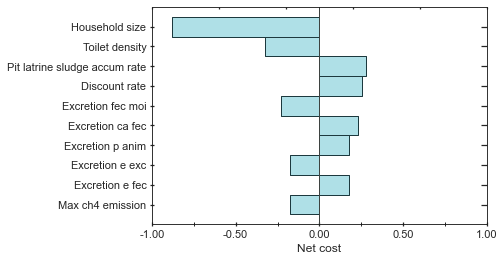

In [9]:
def plot_spearman(model, metric='Net cost', top=None):
    metric = get_param_metric(metric, model, 'metric')
    df = s.get_correlations(modelA, input_y=metric, kind='Spearman')[0]
    fig, ax = s.plot_correlations(df, top=10)
    return fig, ax

fig, ax = plot_spearman(modelA)
fig

[Back to top](#top)

## 3. Country-Specific Analysis <a class="anchor" id="s3"></a>

What will happen if our community locates in a different place? Then we need to replace contextual parameters (e.g., diet, tax rate) in our analyses to those that are specific for the country of interest.

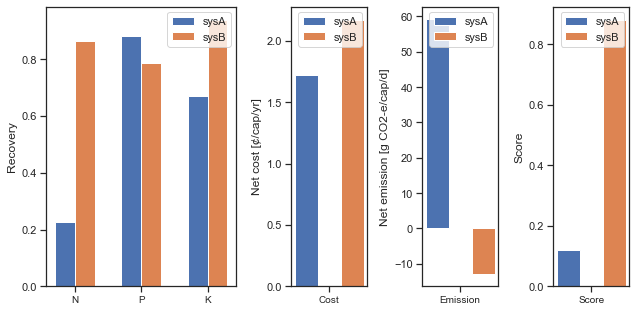

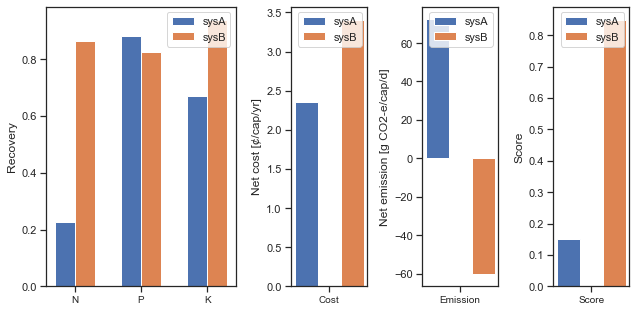

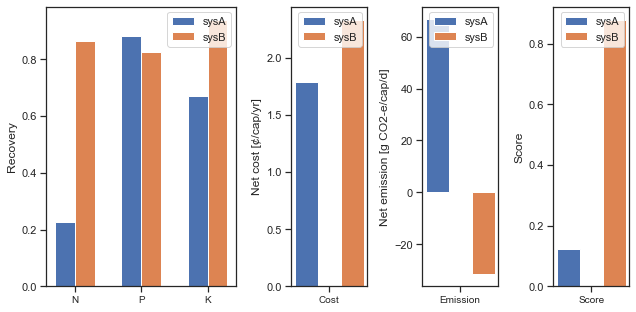

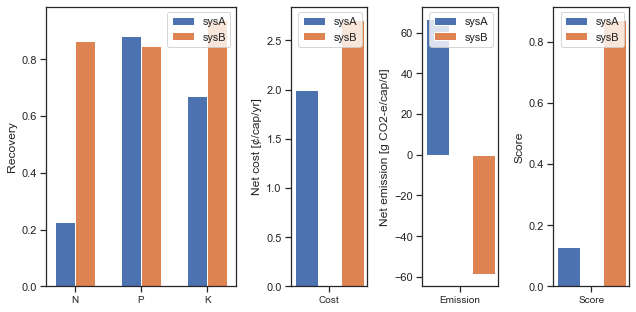

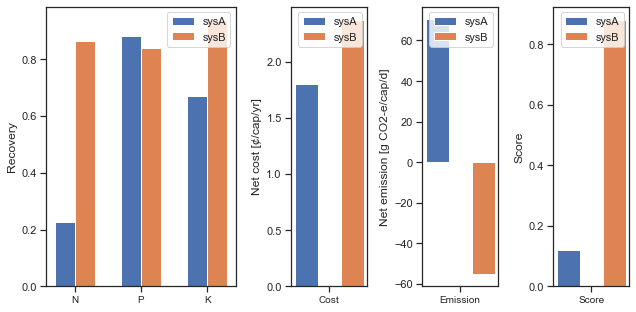

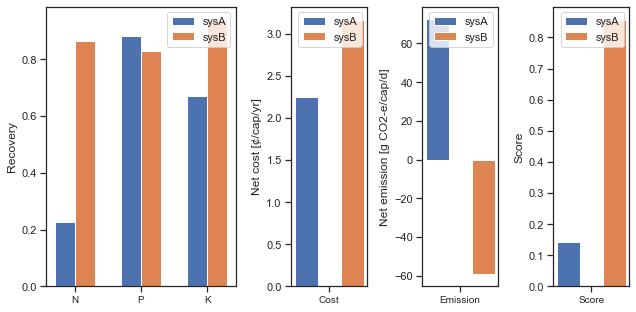

In [10]:
from country_specific import get_val_df, get_results, plot

vals = []
results = []
figs = []
for country in ('Uganda', 'USA', 'India', 'China', 'South Africa', 'Germany'):
    vals.append(get_val_df(country))
    results = get_results(country)
    figs.append(plot(results))

[Back to top](#top)